In [48]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os.path
sys.path.append(
    os.path.abspath(os.path.dirname(os.path.abspath(''))))

from simulation import Parameters
from equations import solveDiscrete, decayLengthPhysical
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import os

# Density on single mt:
dat = []
mt_length = 1000
x = np.arange(0,mt_length*0.008,0.008)
t = np.linspace(0,250,500)
num_PF = 8

for i,filename in enumerate(os.listdir('./config/')):
    if i == i:
        p = Parameters()
        p.read('./config/' + filename)
        solution = solveDiscrete(p,t,mt_length,num_PF)
        accumulation = np.sum(solution-p.alpha,axis=1)
        P_allfree = (1-solution[:,0])**num_PF
        speed = p.v_s * (1-(1-P_allfree)*p.omega) #(1-solution[:,0]*p.omega)
        y = solution[-1]-p.alpha
        y = y/y[0]
        d = decayLengthPhysical(p, speed[-1])
        ye = np.exp(-x/d)
        a = 1 - accumulation/accumulation[-1]
        t_const = t[np.where(a < 0.367879441)[0][0]]
        print(i, 'off from steady state:', (accumulation[-1]-accumulation[-2])/accumulation[-1], 
              'error in decay length:', np.max(y-ye))
        dat.append({'alpha':p.alpha, 'omega':p.omega, 'D':p.D, 'decay_length':d, 't_const':t_const,
                    'speed':speed, 'p':p, 'accumulation':accumulation, 'solution':solution})

0 off from steady state: -8.799473824838054e-09 error in decay length: 0.0
1 off from steady state: -4.131174330343389e-14 error in decay length: 0.0
2 off from steady state: -5.809454278338903e-12 error in decay length: 0.0
3 off from steady state: 4.940984016823186e-10 error in decay length: 0.0
4 off from steady state: 6.258473381594234e-13 error in decay length: 0.0
5 off from steady state: -1.5905487563929237e-15 error in decay length: 0.0
6 off from steady state: -1.734883008752682e-13 error in decay length: 0.0
7 off from steady state: 1.86446919735534e-12 error in decay length: 0.0
8 off from steady state: -2.9101021977681456e-11 error in decay length: 4.602058642400042e-05
9 off from steady state: 2.5180668201869793e-09 error in decay length: 0.00010144674089002104
10 off from steady state: -5.448610345782891e-10 error in decay length: 0.004070806569471119
11 off from steady state: 1.1825291197353695e-09 error in decay length: 0.0030367824426743573
12 off from steady state: -5

In [49]:
import matplotlib
import matplotlib.cm as cm

font = {'size'   : 18}

matplotlib.rc('font', **font)
   
norm = matplotlib.colors.Normalize(vmin=0.4, vmax=1)
cmap = cm.gist_ncar
colors = cm.ScalarMappable(norm=norm, cmap=cmap)

def setMarker(val, permitted_values):
    if val == permitted_values[0]:
        return '^'
    elif val == permitted_values[1]:
        return 'o'
    elif val == permitted_values[2]:
        return 'x'
    elif val == permitted_values[3]:
        return '>'
    
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

def df(plotdic, key):
    if isinstance(plotdic[0][key], float):
        return np.array([dic[key] for dic in plotdic])
    else:
        return np.array([dic[key][-1] for dic in plotdic])
    
def standard_plot(plotdat, xkey, ykey, xfactor, yfactor):
    plt.figure(figsize=(7,7))
    unique_vals = list(set([dic['D'] + dic['p'].v_s for dic in plotdat]))
    print(unique_vals)
    mscatter(df(plotdat,xkey)*xfactor,
         df(plotdat,ykey)*yfactor, 
         c=df(plotdat,'omega'),
         m=[setMarker(dic['D'] + dic['p'].v_s, unique_vals) for dic in plotdat],
         s=200, facecolors='none', alpha=0.6, norm=norm, cmap=cmap)
# colors = list(set(df(plotdat,'omega')))

In [50]:
plotdat = list(filter(lambda dic: dic["p"].v_s == 0.3, dat))
# plotdat = list(filter(lambda dic: dic["D"] == 0.093, plotdat))
# plotdat = dat

In [51]:
file_suffix = str(num_PF) + 'PFs'

[0.393, 1.23, 0.30929999999999996]


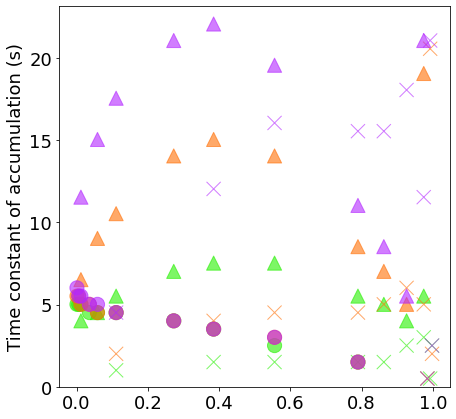

In [52]:
standard_plot(plotdat, 'alpha', 't_const', 1, 1)
plt.ylabel('Time constant of accumulation (s)')
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
plt.savefig("figs/ase1 density vs time constant of accumulation " + file_suffix + ".svg", transparent=True)

[0.393, 1.23, 0.30929999999999996]


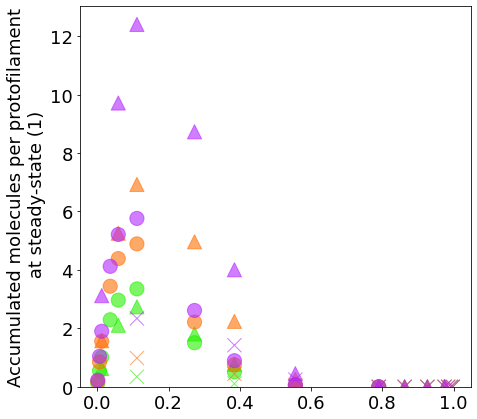

In [53]:
standard_plot(plotdat, 'alpha', 'accumulation', 1, 1)
plt.ylabel("Accumulated molecules per protofilament\n at steady-state (1)")
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
plt.savefig("figs/ase1 density vs accumulated molecules " + file_suffix + ".svg", transparent=True)


[0.393, 1.23, 0.30929999999999996]


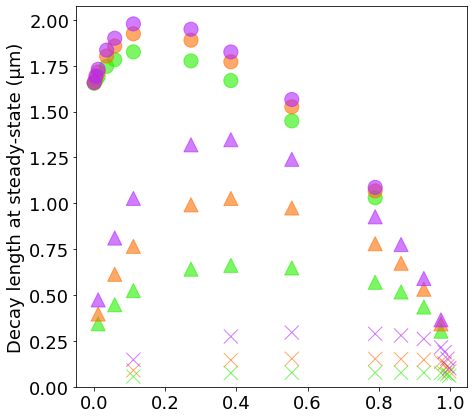

In [54]:
standard_plot(plotdat, 'alpha', 'decay_length', 1, 1)

plt.ylabel("Decay length at steady-state (\u03bcm)")
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
plt.savefig("figs/ase1 density vs decay length " + file_suffix + ".svg", transparent=True)


[0.393, 1.23, 0.30929999999999996]


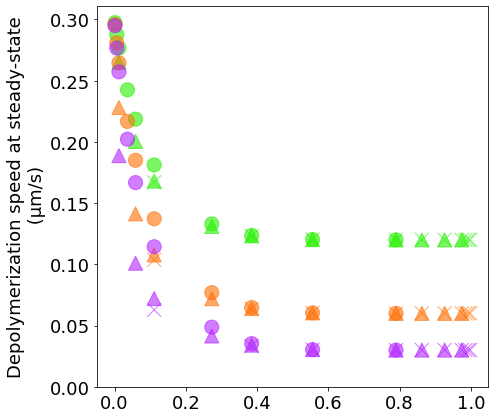

In [55]:
standard_plot(plotdat, 'alpha', 'speed', 1, 1)

plt.ylabel("Depolymerization speed at steady-state\n (\u03bcm/s)")
plt.ylim(0)
plt.savefig("figs/ase1 density vs depolymerization speed " + file_suffix + ".svg", transparent=True)

100
4.509018036072144
9.018036072144287
15.03006012024048


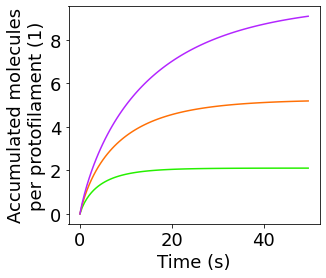

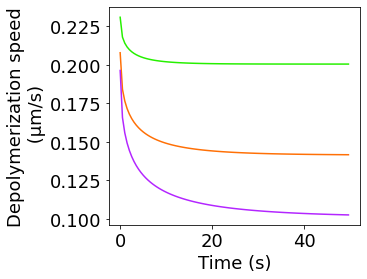

In [56]:
# filtered = list(filter(lambda condition: condition['D'] == 0.0093, plotdat))
filtered = list(filter(lambda condition: 0.1 > condition['alpha'] > 0.05 and condition['D'] == 0.093, plotdat))
plt.figure(figsize=(4.5,4))
tmax = np.where(t >= 50)[0][0]
print(tmax)
for curve in filtered:
    accumulation = curve["accumulation"]
    plt.plot(t[0:tmax],accumulation[0:tmax], label=str(curve["omega"]), color = colors.to_rgba(curve['omega']))
    print(curve["t_const"])
    
plt.xlabel("Time (s)")
plt.ylabel("Accumulated molecules\nper protofilament (1)")
plt.savefig("figs/time vs accumulation " + file_suffix + ".svg")

plt.figure(figsize=(4.5,4))
for curve in filtered:
    solution = curve["solution"]
    P_allfree = (1-solution[:,0])**num_PF
    speed = curve["p"].v_s * (1-(1-P_allfree)*curve["omega"])
    plt.plot(t[0:tmax],speed[0:tmax], label=str(curve["omega"]), color = colors.to_rgba(curve['omega']))
    
plt.xlabel("Time (s)")
plt.ylabel("Depolymerization speed\n (\u03bcm/s)")
plt.savefig("figs/time vs speed " + file_suffix + ".svg")

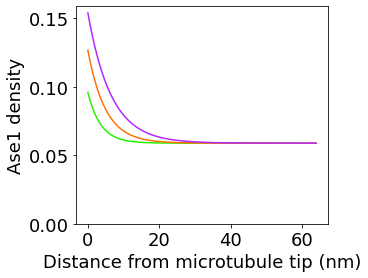

In [57]:
filtered = list(filter(lambda condition: 0.1 > condition['alpha'] > 0.05 and condition['D'] == 0.093, plotdat))
plt.figure(figsize=(4.5,4))
for curve in filtered:
    solution = curve["solution"]
    y = solution[-1][:]
    plt.plot(x*8,y, color = colors.to_rgba(curve['omega']))

plt.ylim(0)
plt.xlabel("Distance from microtubule tip (nm)")
plt.ylabel("Ase1 density")
plt.savefig("figs/distance versus Ase1 density " + file_suffix + ".svg")

# d = decayLengthPhysical(dat[index]["p"], dat[index]["speed"][-1])
# ye = np.exp(-x/d)
# np.max(y-ye)
# plt.plot(x,ye)

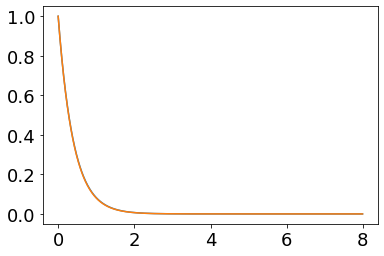

In [58]:
index = 40

y = dat[index]["solution"][-1]-dat[index]["alpha"]
y = y/y[0]

plt.plot(x,y)
d = decayLengthPhysical(dat[index]["p"], dat[index]["speed"][-1])
ye = np.exp(-x/d)
np.max(y-ye)
plt.plot(x,ye)